In [6]:
""" REMEMBER TO CHANGE ALSO GET_SPECIALR"""

' REMEMBER TO CHANGE ALSO GET_SPECIALR'

In [22]:
from src.Utilities.isalice import isalice
alice, plot = isalice()

# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt
import colorcet

# Chocolate Imports
# from src.Opacity.opacity_table import opacity
from src.Opacity.cloudy_opacity import old_opacity #TEST OLD OPACITY
from src.Calculators.ray_tree import ray_maker
from src.Luminosity.special_radii_tree_cloudy import get_specialr
from src.Calculators.select_observers import select_observer 
from src.Luminosity.select_path import select_snap
from datetime import datetime
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [5 , 4]
pre = '/home/s3745597/data1/TDE/tde_comparison'

# Constants
c = 2.99792458e10 #[cm/s]
h = 6.62607015e-27 #[gcm^2/s]
Kb = 1.380649e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10

In [8]:
# def select_observer(wanted_theta, wanted_phi, thetas, phis):
#     """ Gives thetas, phis from helpix and 
#     the index of the points closer to the one given by (wanted_theta, wanted_phi)"""
#     dist = np.zeros(192)
#     # list_index = []
#     for i in range(len(thetas)): 
#         delta_theta = wanted_theta -  thetas[i]
#         delta_phi = wanted_phi -  phis[i]
#         # Haversine formula
#         arg = np.sin(delta_theta / 2)**2 + np.cos(wanted_theta) * np.cos(thetas[i]) * np.sin(delta_phi/2)**2
#         dist[i] = 2 * np.arctan2( np.sqrt(arg), np.sqrt(1-arg))
#         # check all nearest observers
#         # if np.abs(np.abs(dist[i])-dist.min())<1e-16:
#         #     print(i, dist[i])
#         #     list_index.append(i)
#     index = np.argmin(np.abs(dist))
#     print(index)
#     return index

In [9]:
def log_array(n_min, n_max, lenght):
    x_min = np.log10(n_min)
    x_max = np.log10(n_max)
    x_arr = np.linspace(x_min, x_max , num = lenght)
    return x_arr

def planck(Temperature: float, n: float) -> float:
    """ Planck function in a cell. It needs temperature and frequency n. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)

    return fun

def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n: float):
    """ Luminosity in a cell: L_n = \epsilon e^(-\tau) B_n / B 
    where  B = \sigma T^4/\pi"""
    Tmax = np.power(10,8) #np.exp(17.87) #TEST OLD OPACITY
    if Temperature > Tmax:
        # Scale as Kramers the last point 
        # kplanck_0 = opacity(Tmax, Density, 'planck', ln = False)
        kplanck_0 = old_opacity(Tmax, Density, 'planck') #TEST OLD OPACITY
        k_planck = kplanck_0 * (Temperature/Tmax)**(-3.5)
    else:
        # k_planck = opacity(Temperature, Density, 'planck', ln = False)
        k_planck = old_opacity(Temperature, Density, 'planck') #TEST OLD OPACITY

    L = 4  * np.pi * k_planck * volume * np.exp(-tau) * planck(Temperature, n)
    return L

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over n_array = 10^{x_array} (!!!), 
    find the normalisation constant for L_tilde_n from FLD model. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

def find_sph_coord(theta,phi):
    x = np.sin(np.pi-theta) * np.cos(phi) #because theta should start from the z axis: we're flipped
    y = np.sin(np.pi-theta) * np.sin(phi)
    z = np.cos(np.pi-theta)
    xyz = [x, y, z]
    return x,y,z

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over n_array = 10^{x_array} (!!!), 
    find the normalisation constant for L_tilde_n from FLD model. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

In [10]:
print(find_sph_coord(np.pi/2,np.pi))

(-1.0, 1.2246467991473532e-16, 6.123233995736766e-17)


In [11]:
# Choose BH 
m = 6
check = 'fid'
num = 5000
snapshots, days = select_snap(m, check)

# Load data for normalsation 
fld_data = np.loadtxt('data/red/reddata_m'+ str(m) + check +'.txt')
luminosity_fld_fix = fld_data[1]

# Choose freq range
n_min = 2.08e13
n_max = 6.25e23
n_spacing = 100 # Elad used 1000, but no difference
x_arr = log_array(n_min, n_max, n_spacing)
n_arr = 10**x_arr

In [12]:
# Choose the observers: theta in [0, pi], phi in [0,2pi]
wanted_thetas = [np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi, 0] # x, -x, y, -y, z, -z
wanted_phis = [0, np.pi, np.pi/2, 3*np.pi/2, 0, 0]

Text(0.5, 0.92, 'Wanted observers')

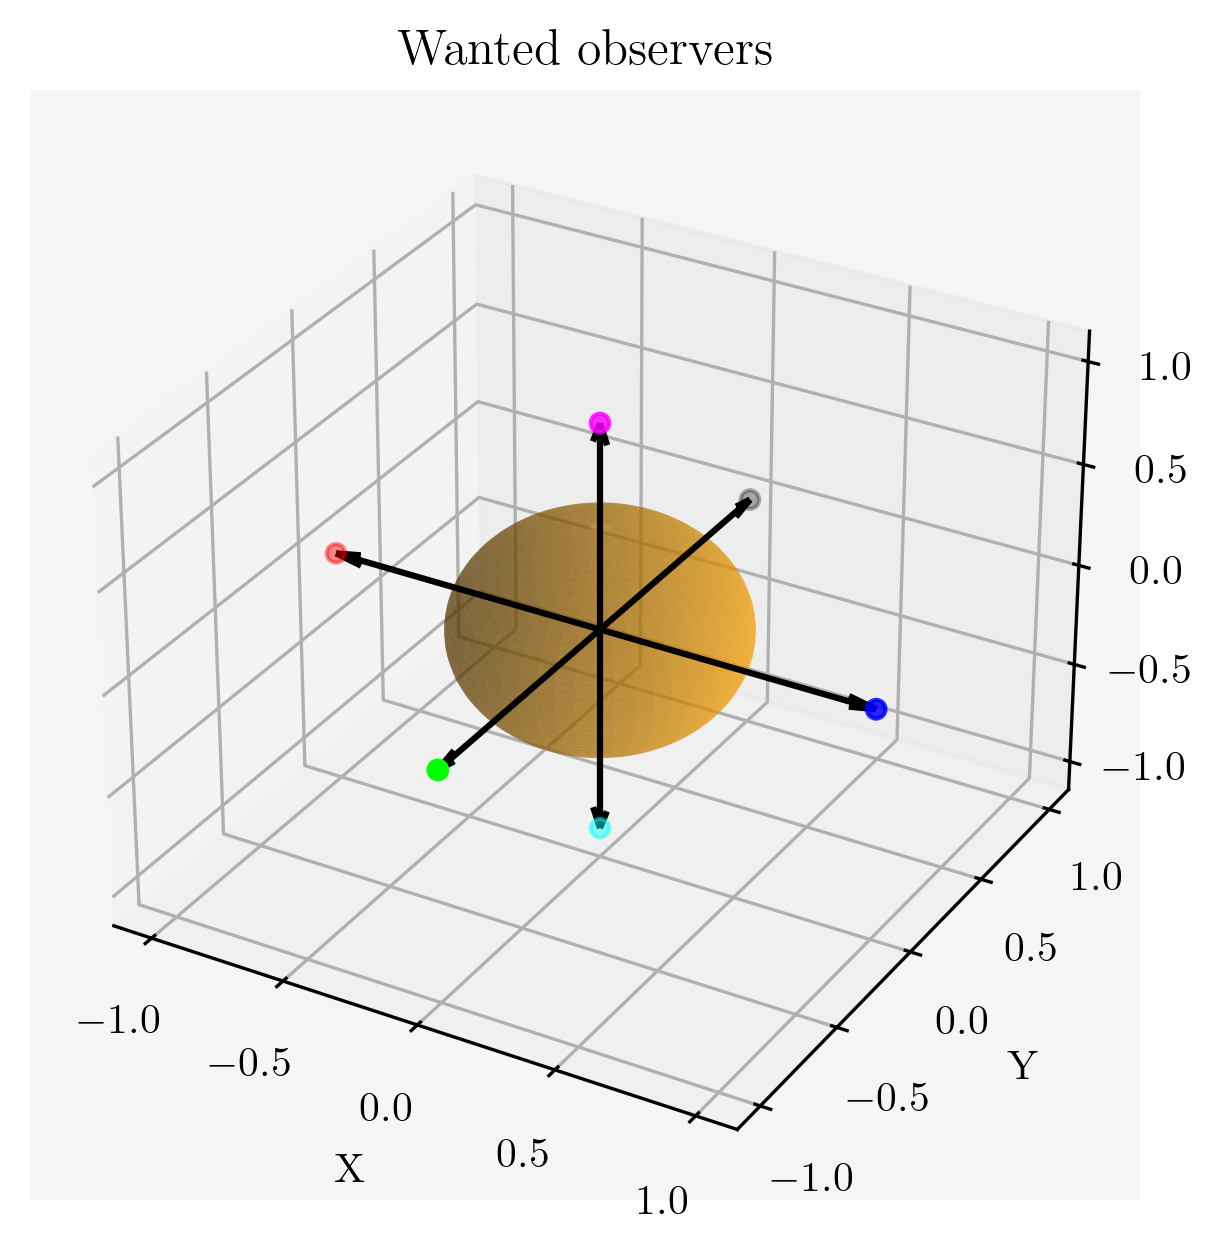

In [13]:
x_wanted = np.zeros(len(wanted_thetas))
y_wanted = np.zeros(len(wanted_thetas))
z_wanted = np.zeros(len(wanted_thetas)) 
for i in range(len(wanted_thetas)):
    x_wanted[i], y_wanted[i], z_wanted[i] = find_sph_coord(wanted_thetas[i], wanted_phis[i])

# Plot the ones chosen 
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
# Create a sphere
r = 0.5
phi_sph, theta_sph = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = r*np.sin(phi_sph)*np.cos(theta_sph)
y = r*np.sin(phi_sph)*np.sin(theta_sph)
z = r*np.cos(phi_sph)
ax.plot_surface(x, y, z, color='orange', alpha = 0.5)

#Set arrow for axis
xar = np.zeros(len(x_wanted))
yar = np.zeros(len(x_wanted))
zar = np.zeros(len(x_wanted))
col = ['b', 'r', 'k', 'lime', 'magenta', 'aqua']
ax.quiver(xar, yar, zar, x_wanted, y_wanted, z_wanted, arrow_length_ratio=0.1, color = 'k')

ax.scatter(x_wanted,y_wanted,z_wanted, color = col, s=20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.title('Wanted observers')

In [14]:
# thetas = np.zeros(192)
# phis = np.zeros(192) 
# for i in range(0,192):
#     thetas[i], phis[i] = hp.pix2ang(4, i)

# for idx in range(len(wanted_thetas)):
#     wanted_theta = wanted_thetas[idx]
#     wanted_phi = wanted_phis[idx]
#     wanted_indexes = select_observer(wanted_theta, wanted_phi, thetas, phis)

#     x_selected = np.zeros(len(wanted_indexes))
#     y_selected = np.zeros(len(wanted_indexes))
#     z_selected = np.zeros(len(wanted_indexes))
    
#     print(wanted_indexes)
#     for k in range(len(wanted_indexes)):
#         wanted_index = wanted_indexes[k]
#         x_selected[k], y_selected[k], z_selected[k] = find_sph_coord(thetas[wanted_index], phis[wanted_index])

# # print('X:' , x_selected)
# # print('Y:' , y_selected)
# # print('Z:' , z_selected)


# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')
# # Create a sphere
# r = 0.5
# phi_sph, theta_sph = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
# x = r*np.sin(phi_sph)*np.cos(theta_sph)
# y = r*np.sin(phi_sph)*np.sin(theta_sph)
# z = r*np.cos(phi_sph)
# ax.plot_surface(x, y, z, color='orange', alpha = 0.5)

# #Set arrow for axis
# xar = np.zeros(len(x_wanted))
# yar = np.zeros(len(x_wanted))
# zar = np.zeros(len(x_wanted))
# # ax.quiver(xar,yar,zar, dx, dy, dz, arrow_length_ratio=0.1, color = 'k')
# col = ['b', 'r', 'k', 'lime', 'magenta', 'lightskyblue', 'violet', 'tomato', 'grey', 'gold']
# ax.quiver(xar, yar, zar, x_wanted, y_wanted, z_wanted, arrow_length_ratio=0.1, color = 'k')

# ax.scatter(x_selected,y_selected,z_selected, color = col, s=20)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.tight_layout()
# plt.title('Healpix observers for direction x')

In [15]:
snap = 881

# Find observers 
tree_indexes, observers, rays_T, rays_den, _, radii, rays_vol = ray_maker(snap, m, check, num)

In [16]:
thetas = np.zeros(192)
phis = np.zeros(192) 
x = np.zeros(192) 
y = np.zeros(192) 
z = np.zeros(192) 
for iobs in range(len(observers)): 
    thetas[iobs] = observers[iobs][0]
    phis[iobs] =  observers[iobs][1]
    x[iobs], y[iobs], z[iobs] = (find_sph_coord(thetas[iobs], phis[iobs]))

Text(0.5, 1.0, 'Observers ($\\theta_{mid}\\approx\\pi/2$)')

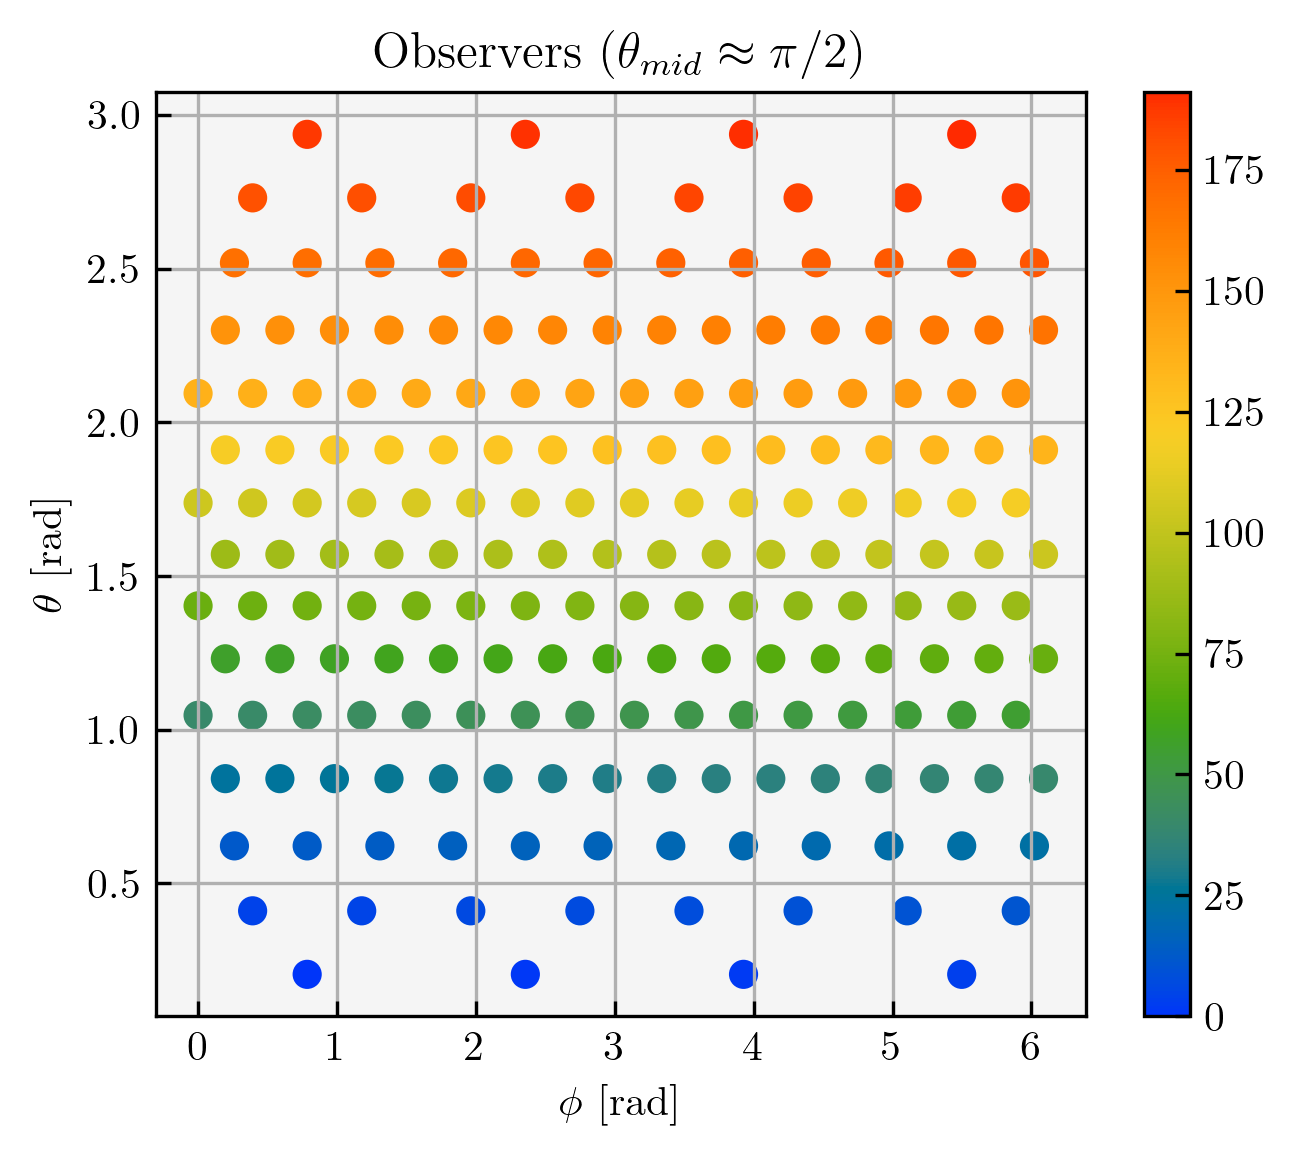

In [23]:
plt.figure()
img = plt.scatter(phis, thetas, c=np.arange(192), cmap = 'cet_rainbow')
plt.colorbar(img)
plt.xlabel(r'$\phi$ [rad]')
plt.ylabel(r'$\theta$ [rad]')
plt.grid(True)
plt.title(r'Observers ($\theta_{mid}\approx\pi/2$)')

In [ ]:
# thetas_toplot= thetas - np.pi/2 # Enforce theta in -pi/2 to pi/2
# phis_tolpot = phis- np.pi # Enforce theta in -pi to pi

# fig, ax = plt.subplots(1,1, subplot_kw=dict(projection="mollweide"))
# img = ax.scatter(phis_tolpot, thetas_toplot, c = np.arange(192), s=20, marker = 'h', cmap=plt.cm.jet)
# ax.set_title('Equatorial plane: observers 88-103', fontsize = 10)
# cbar = fig.colorbar(img)
# cbar.set_label('Observer', fontsize = 8)
# plt.grid(True)

In [ ]:
# plt.figure()
# plt.plot(np.arange(num), radii/Rsol_to_cm, color = 'dodgerblue')
# plt.yscale('log')
# plt.xlabel('cell')
# plt.ylabel(r'log$_{10}$(cell dimension) [R$_\odot$]')
# plt.title('Our radii')

In [ ]:
# Find voulume of cells
volume = np.zeros(len(radii)-1)
for i in range(len(volume)): 
    dr = radii[i+1] - radii[i]
    volume[i] = 4 * np.pi * radii[i]**2 * dr / 192  

Text(0.5, 1.0, 'Volume')

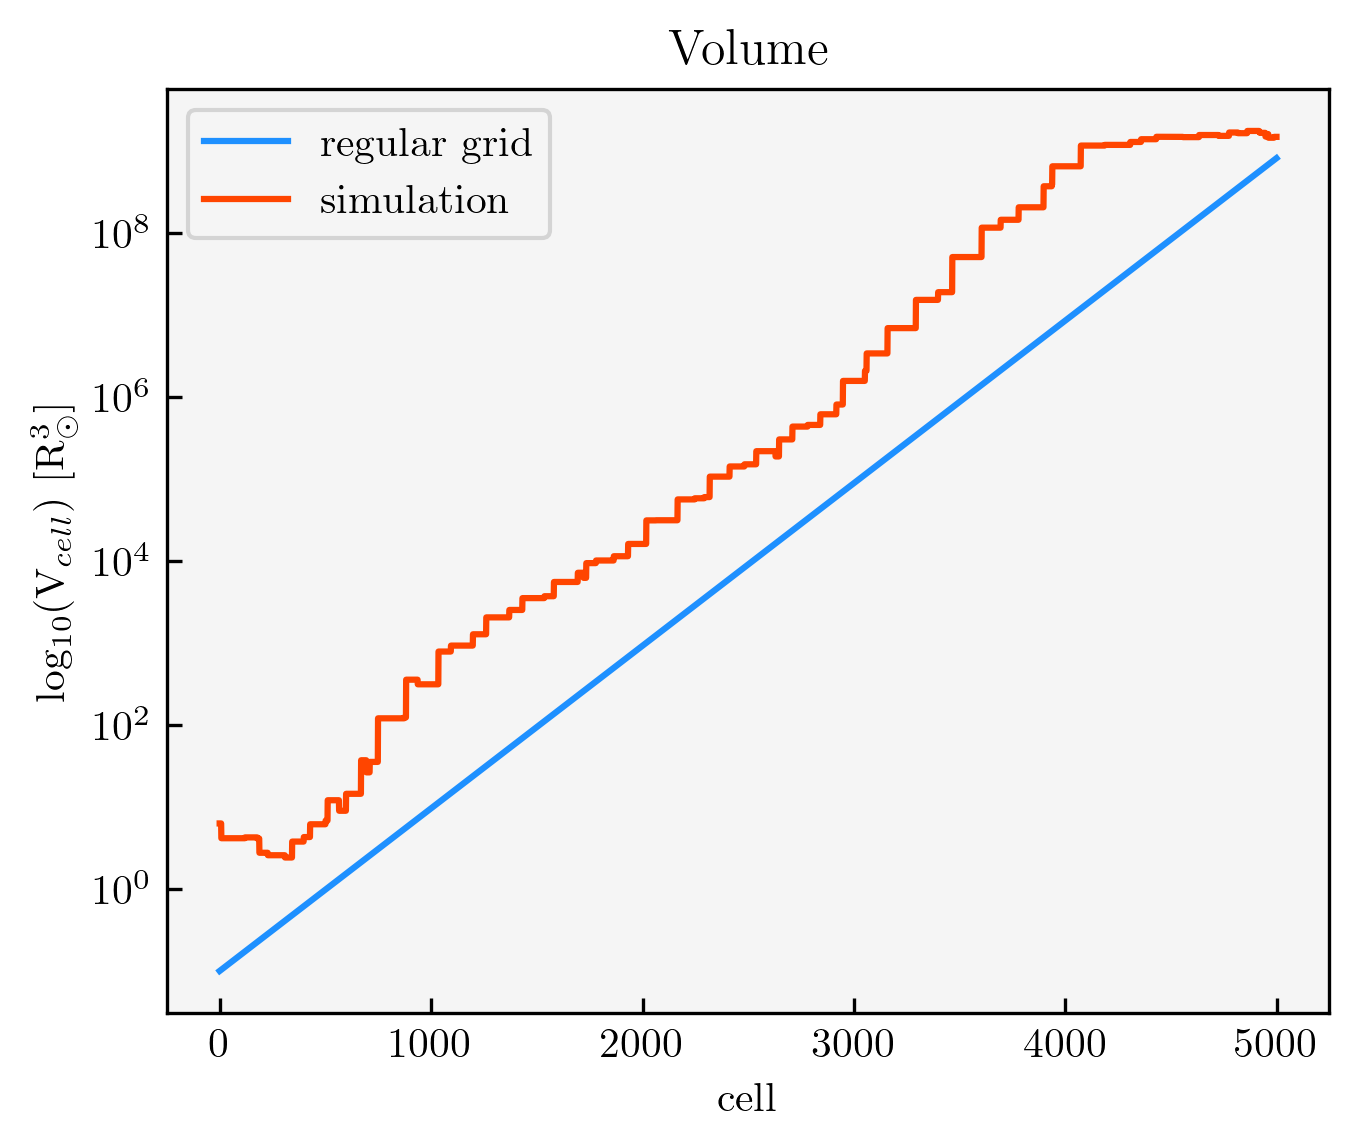

In [ ]:
plt.figure()
plt.plot(np.arange(num-1), volume/Rsol_to_cm**3, color = 'dodgerblue', label = 'regular grid')
plt.plot(np.arange(num-1), rays_vol[20], color = 'orangered', label = 'simulation')
plt.yscale('log')
plt.xlabel('cell')
plt.ylabel(r'log$_{10}$(V$_{cell}$) [R$^3_\odot$]')
plt.legend()
plt.title('Volume')

In [ ]:
radii = np.delete(radii, -1)

In [ ]:
rays_kappas, rays_cumulative_taus, rays_specialr, rays_index_specialr, tree_index_specialr = get_specialr(rays_T, rays_den, radii, tree_indexes, select = 'thermr')# Get thermalisation radius

In [ ]:
_, rays_cumulative_phkappas, rays_ph, rays_index_ph, tree_index_ph = get_specialr(rays_T, rays_den, radii, tree_indexes, select = 'photo')

In [ ]:
taus_ph = np.zeros(192) #for photosphere
pretaus = np.zeros(192) #for R_therm
taus = np.zeros(192) #for R_therm
T_therm = np.zeros(192)
rho_therm = np.zeros(192)
single_cell = []
for i in range(192):
    if len(rays_cumulative_taus[i])>1:
        pretaus[i] = rays_cumulative_taus[i][-2]
        taus_ph[i] = rays_cumulative_phkappas[i][-1]
        taus[i] = rays_cumulative_taus[i][-1]
        index = int(rays_index_specialr[i])
        T_therm[i] = rays_T[i][index]
        rho_therm[i] = rays_den[i][index]
    else:
        single_cell.append(i)
        pretaus[i] = rays_cumulative_taus[i][0]
        taus_ph[i] = rays_cumulative_phkappas[i][0]
        taus[i] = rays_cumulative_taus[i][0]
        index = int(rays_index_specialr[i])
        T_therm[i] = rays_T[i][index]
        rho_therm[i] = rays_den[i][index]


In [ ]:
print('Therm r far away: ', single_cell)
print('R_th: ', rays_specialr[single_cell]/Rsol_to_cm, 'R_sol')

Therm r far away:  []
R_th:  [] R_sol


In [ ]:
log_rhotherm = np.log10(rho_therm)
log_rhotherm = np.nan_to_num(log_rhotherm)

Tmin = np.exp(8.666)
print(Tmin)
Tmax = np.exp(17.876)
logTtherm = np.log10(T_therm/Tmin)
logTtherm = np.nan_to_num(logTtherm)

5802.243894044859


In [ ]:
print(pretaus)

[4.98088169 4.95148866 4.99600923 4.99159265 4.95591252 4.99448487
 4.93994135 4.89202949 4.96881133 4.70110698 4.85360914 4.99549673
 4.98821001 4.98582593 4.9989194  4.97364536 4.93801804 4.98842776
 4.97960056 4.99606549 4.97406946 4.97995526 4.98649794 4.98275864
 4.99640807 4.97147398 4.96403677 4.99665176 4.96940122 4.98686324
 4.79367385 4.84026558 4.96977446 4.91089486 4.99320054 4.98203668
 4.9256759  4.96576707 4.95964586 4.98100528 4.99582466 4.91843754
 4.98154784 4.89999319 4.92179824 4.8613585  4.97106601 4.81802646
 4.80056984 4.96422572 4.93681988 4.94846377 4.9499227  4.9671703
 4.94686628 4.9675598  4.92405712 4.66402118 4.45550328 4.7383281
 4.76275842 4.87565786 4.96028281 4.8126022  4.99682155 4.74095027
 4.79009296 4.73480668 4.78914481 4.86649249 4.99023213 4.98586876
 4.93184812 4.76209432 4.77896208 4.93788373 4.91165126 4.95479272
 4.92210444 4.99088093 4.97825142 4.98379266 4.99707332 4.77138006
 4.47373151 4.82275055 4.94805443 4.95719938 4.85862453 4.961936

Text(0.5, 1.0, 'R$_{therm}$')

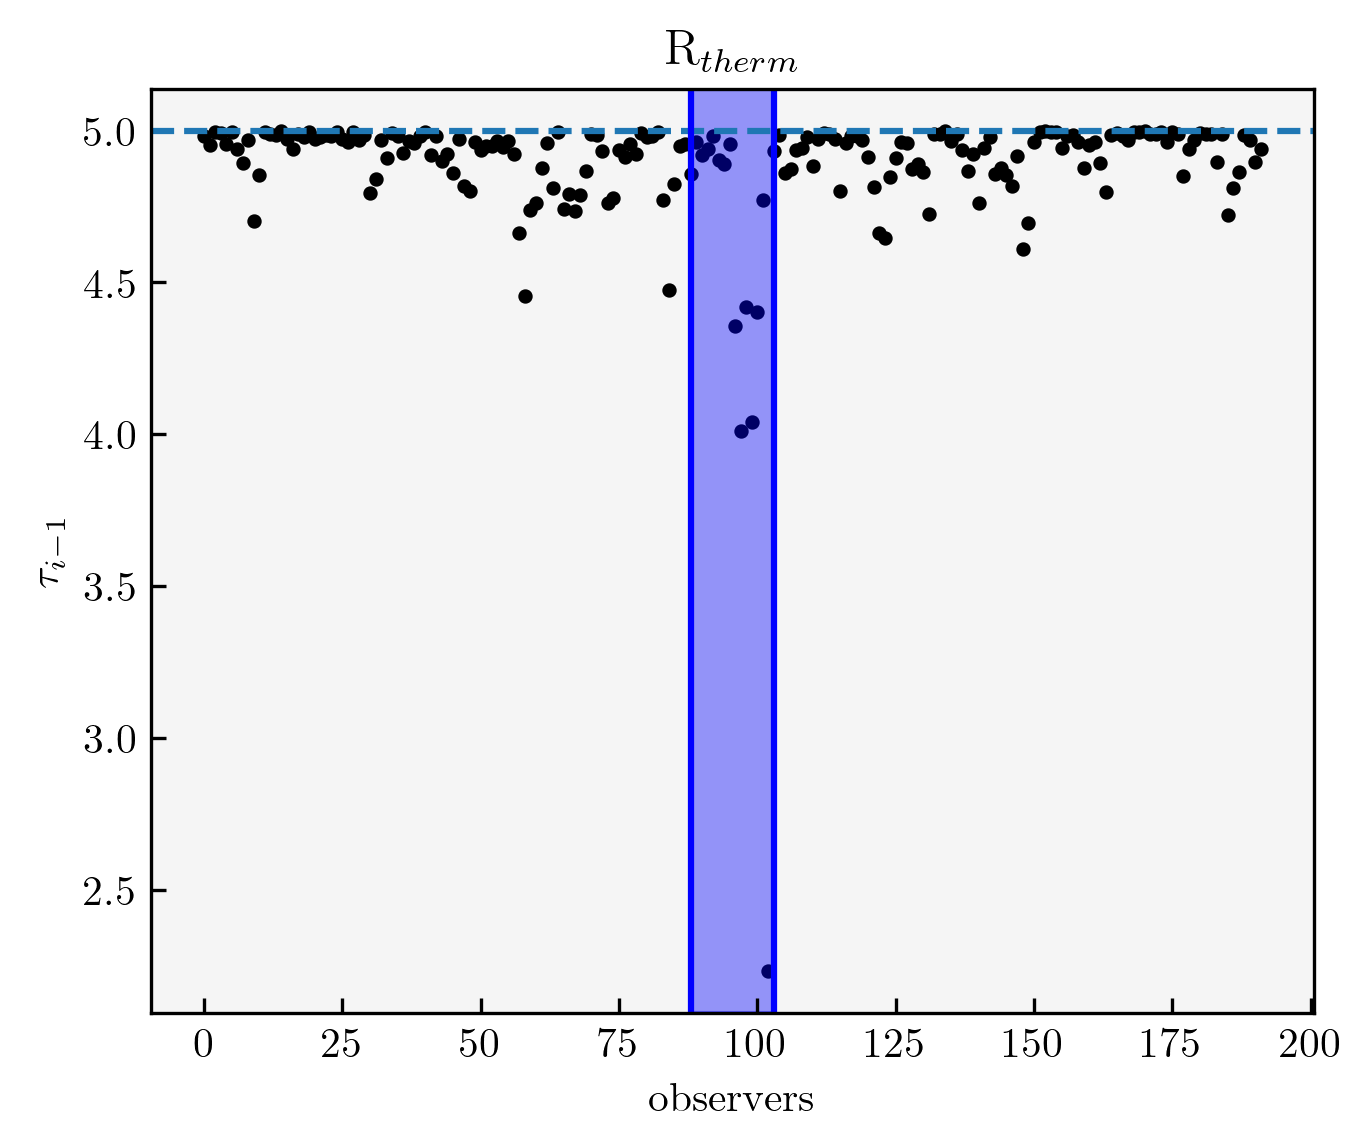

In [ ]:
plt.scatter(np.arange(192), pretaus, s = 6, c = 'k')
plt.axhline(5, linestyle = 'dashed')
plt.axvline(88, color = 'b')
plt.axvline(103, color = 'b')
plt.axvspan(88, 103, alpha=0.4, color = 'b')
plt.ylabel(r'$\tau_{i-1}$')
plt.xlabel('observers')
plt.title(r'R$_{therm}$')


In [ ]:
minimum = np.argmin(np.abs(pretaus-2.5))
print(taus[minimum])

7.052260270120395


Text(0.5, 1.0, 'R$_{therm}$')

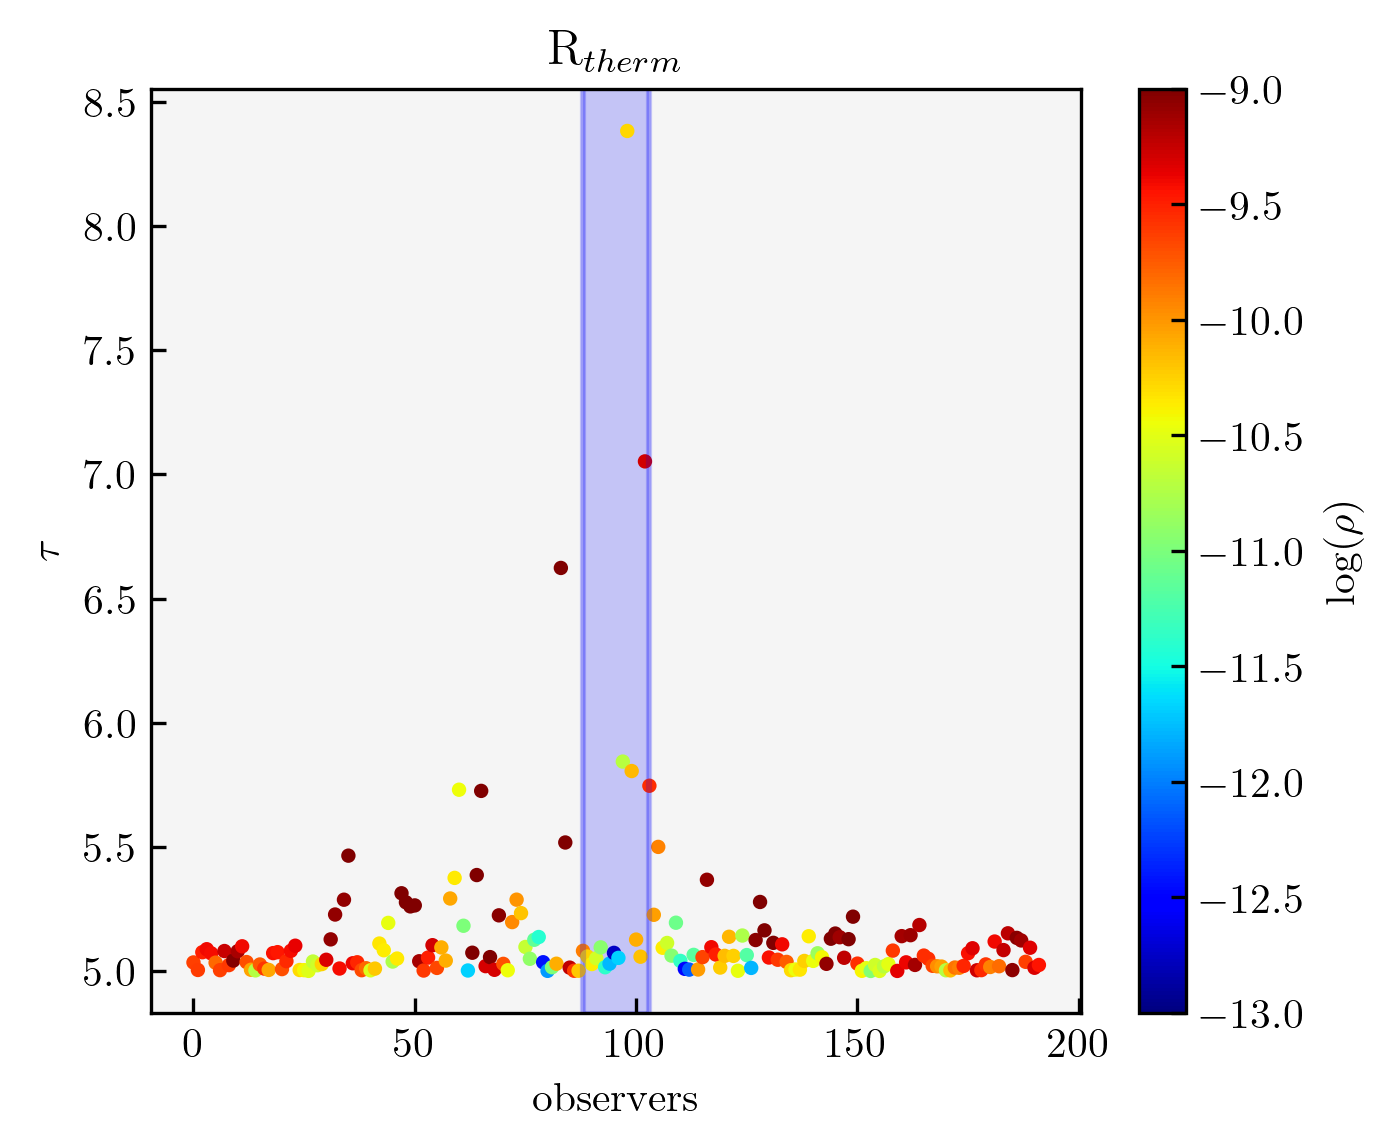

In [ ]:
for single in single_cell:
    plt.axvline(single, alpha=0.4, color = 'k', linestyle = 'dashed')
plt.axvline(88, alpha=0.2, color = 'b')
plt.axvline(103, alpha=0.2, color = 'b')
plt.axvspan(88, 103, alpha=0.2, color = 'b')
img = plt.scatter(np.arange(192), taus, s = 6, c = log_rhotherm, cmap = 'cet_rainbow', vmin = -13, vmax = -9)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log(\rho)$')
plt.ylabel(r'$\tau$')
plt.xlabel('observers')
plt.title(r'R$_{therm}$')

Text(0.5, 1.0, 'R$_{ph}$')

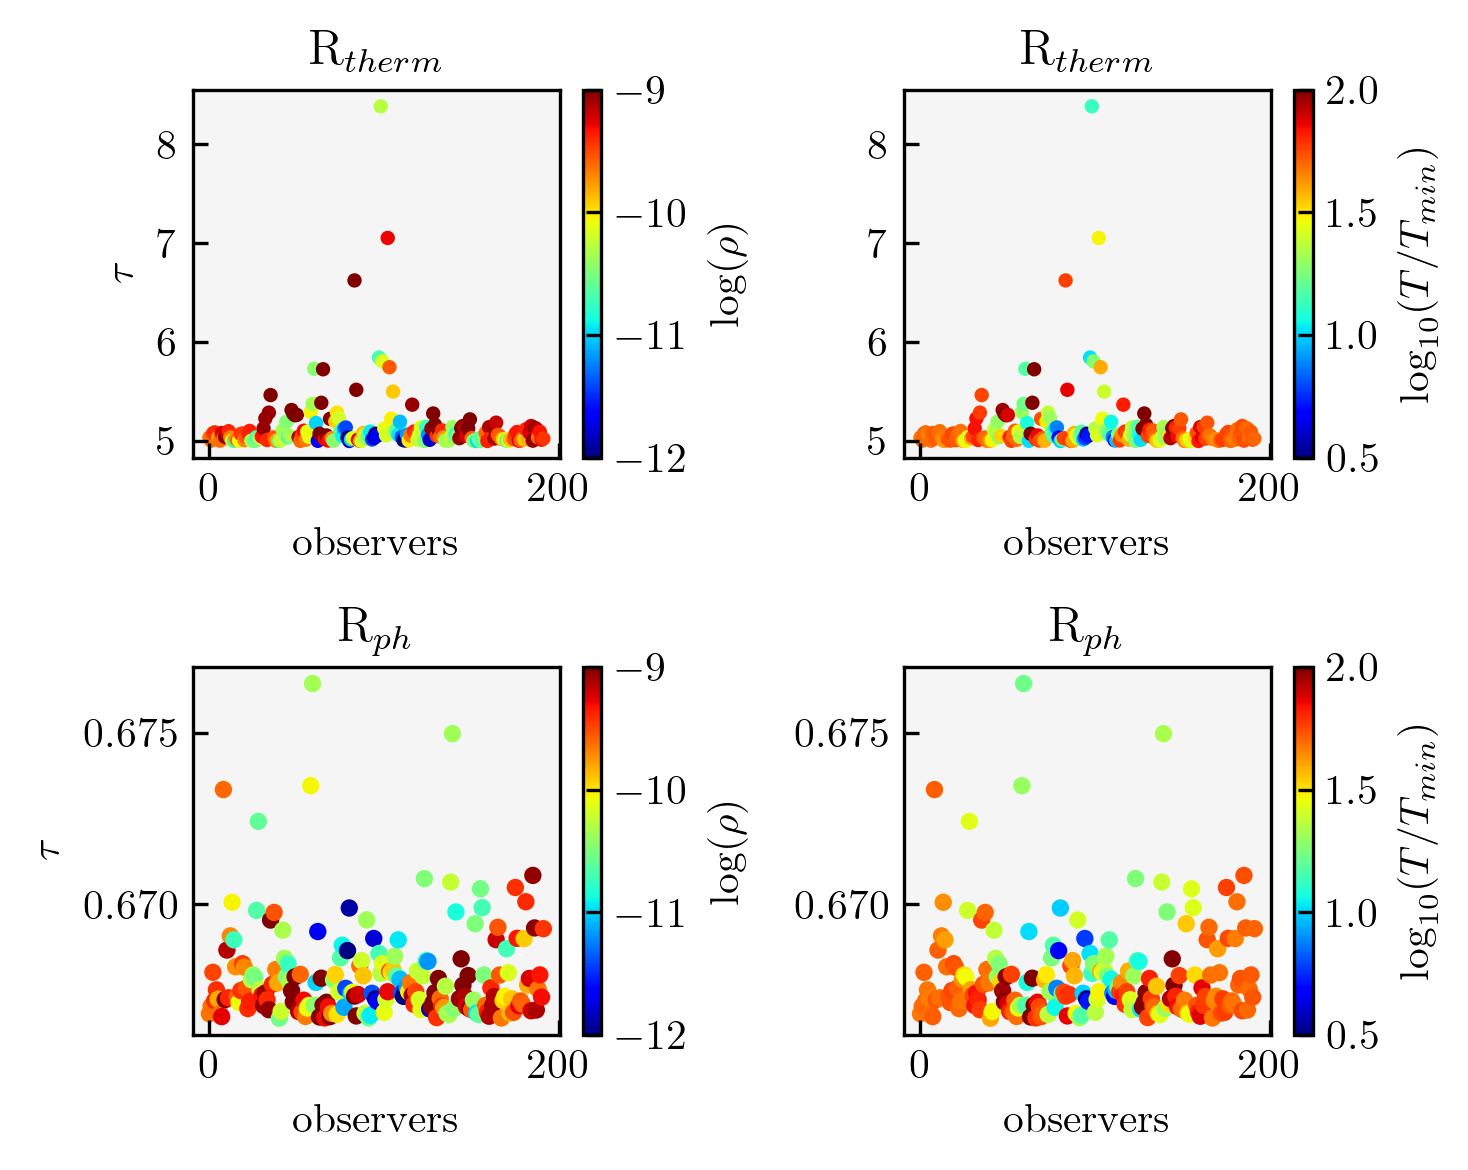

In [ ]:
fig, axs = plt.subplots(2,2, tight_layout = True)
img = axs[0][0].scatter(np.arange(192), taus, s = 6, c = log_rhotherm, cmap = 'cet_rainbow', vmin = -12, vmax = -9)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log(\rho)$')
axs[0][0].set_ylabel(r'$\tau$')
axs[0][0].set_xlabel('observers')
#axs[0][0].set_ylim(3,20)
axs[0][0].set_title(r'R$_{therm}$')

img2 = axs[0][1].scatter(np.arange(192), taus, s = 6, c = logTtherm, cmap = 'cet_rainbow', vmin = 0.5, vmax = 2) #np.log10(Tmax/Tmin))
cbar = plt.colorbar(img2)
cbar.set_label(r'$\log_{10}(T/T_{min})$')
#axs[0][1].set_ylabel(r'$\tau$')
axs[0][1].set_xlabel('observers')
#axs[0][1].set_ylim(3, 20)
axs[0][1].set_title(r'R$_{therm}$')

img = axs[1][0].scatter(np.arange(192), taus_ph, s = 10, c = log_rhotherm, cmap = 'cet_rainbow', vmin = -12, vmax = -9)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log(\rho)$')
axs[1][0].set_ylabel(r'$\tau$')
axs[1][0].set_xlabel('observers')
#axs[1][0].set_ylim(0.3, 1.5)
axs[1][0].set_title(r'R$_{ph}$')

img2 = axs[1][1].scatter(np.arange(192), taus_ph, s = 10, c = logTtherm, cmap = 'cet_rainbow', vmin = 0.5, vmax = 2)#np.log10(Tmax/Tmin))
cbar = plt.colorbar(img2)
cbar.set_label(r'$\log_{10}(T/T_{min})$')
#axs[1][1].set_ylabel(r'$\tau$')
axs[1][1].set_xlabel('observers')
#axs[1][1].set_ylim(0.3, 1.5)
axs[1][1].set_title(r'R$_{ph}$')

# for i in range(2):
#     for j in range(2):
#         ax[i][j].axvline(88, color = 'b')
#         ax[i][j].axvline(103, color = 'b')
        # ax[i][j].axvspan(88, 103, alpha=0.4, color = 'b')

Text(0.5, 0, 'observers')

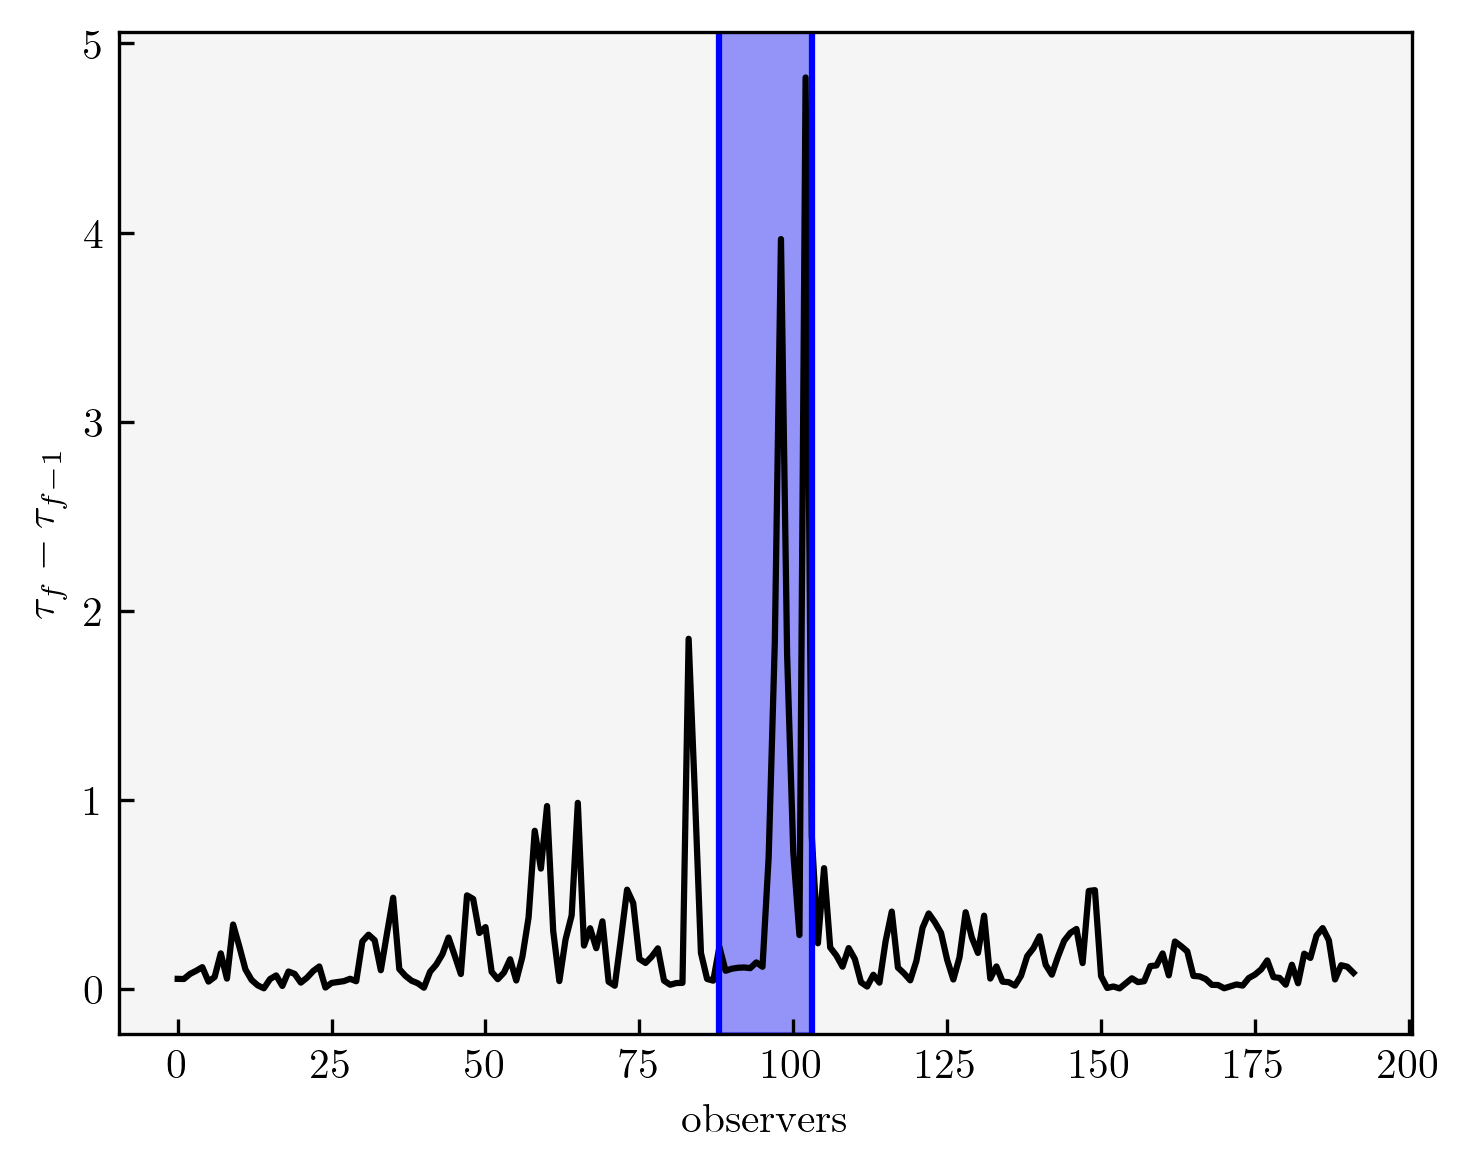

In [ ]:
fig, ax = plt.subplots(tight_layout = True)
plt.plot(np.arange(192), taus-pretaus, c = 'k')
plt.axvline(88, color = 'b')
plt.axvline(103, color = 'b')
plt.axvspan(88, 103, alpha=0.4, color = 'b')
for single in single_cell:
    plt.axvline(single, color = 'r', linestyle = 'dashed')
ax.set_ylabel(r'$\tau_f-\tau_{f-1}$')
ax.set_xlabel('observers')


In [ ]:
wanted_theta = wanted_thetas[1]
wanted_phi = wanted_phis[1]
wanted_index = select_observer(wanted_theta, wanted_phi, thetas, phis)
xyz_selected = find_sph_coord(thetas[wanted_index], phis[wanted_index])

In [ ]:
dot_product = np.zeros(len(observers))
for iobs in range(len(observers)):
    xyz = find_sph_coord(thetas[iobs], phis[iobs])
    dot_product[iobs] = np.dot(xyz_selected, xyz)
# set the negative dot product to 0
    if dot_product[iobs] < 0:
        dot_product[iobs] = 0
dot_product *= 4/192 # normalisation from Elad

In [ ]:
x_healpix = np.zeros(192)
y_healpix = np.zeros(192)
z_healpix = np.zeros(192)
for iobs in range(len(observers)): 
    thetas[iobs] = observers[iobs][0]
    phis[iobs] =  observers[iobs][1]
    x_healpix[iobs], y_healpix[iobs], z_healpix[iobs] = find_sph_coord(thetas[iobs], phis[iobs])

In [ ]:
color_plot = []
for i in range(len(observers)):
    if dot_product[i] == 0:
        color_plot.append('k')
    else:
        color_plot.append('b')

Text(0.5, 0.92, 'Who do we take?')

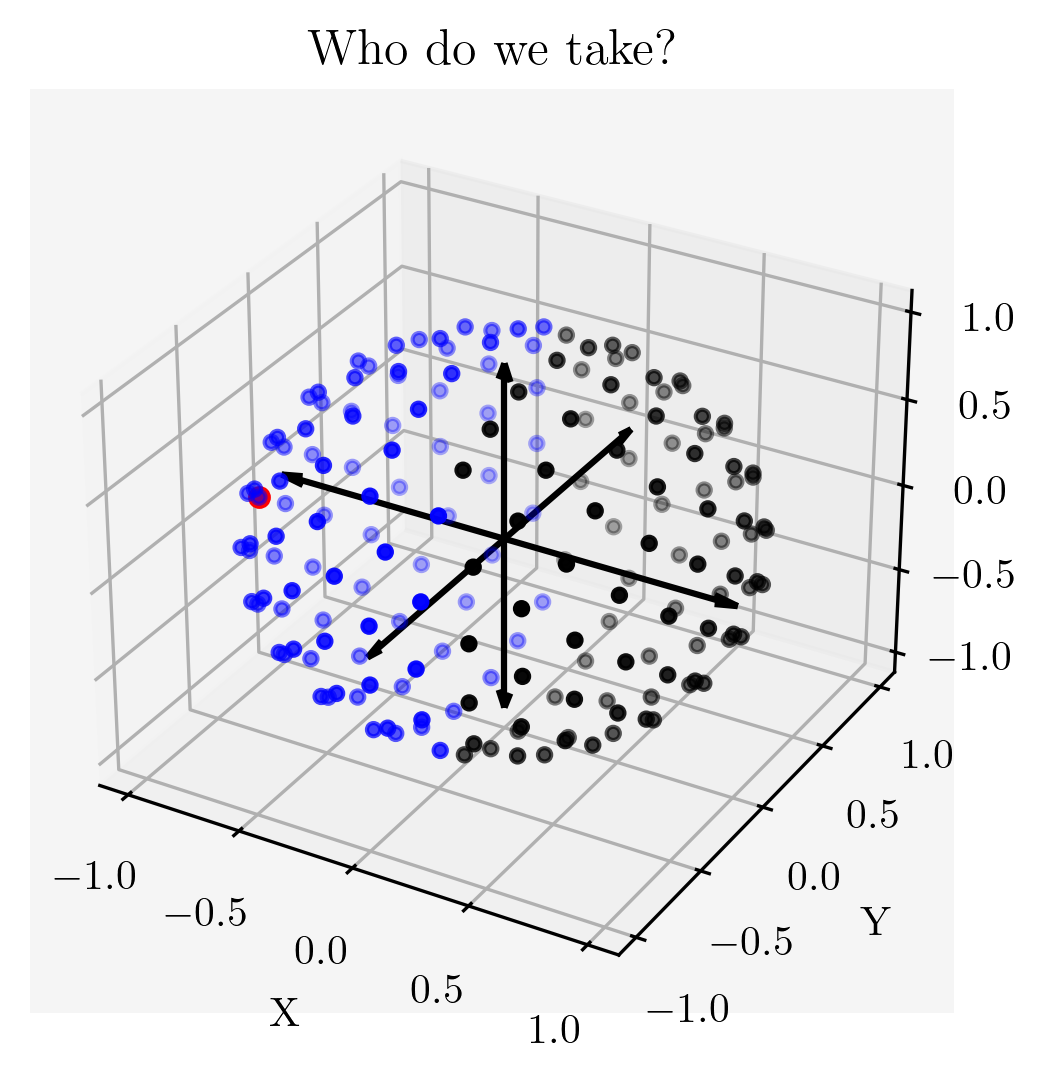

In [ ]:
# Plot healpix with axis 
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(x_healpix, y_healpix, z_healpix, color = color_plot, s=10)
ax.scatter(xyz_selected[0], xyz_selected[1], xyz_selected[2], c = 'r')
ax.quiver(xar, yar, zar, x_wanted, y_wanted, z_wanted, arrow_length_ratio=0.1, color = 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Who do we take?')